In [73]:
# ===== Reduced Order Modeling with NGSolve + pyMOR (POD-Galerkin) =====
import numpy as np
from ngsolve import *
from netgen.geom2d import unit_square

from pymor.algorithms.pod import pod
from pymor.vectorarrays.numpy import NumpyVectorSpace
import matplotlib.pyplot as plt


In [82]:
# ==========================================================
# 1) High-fidelity model (FOM) with parametric 2x2 κ-matrix
# ==========================================================
mesh = Mesh(unit_square.GenerateMesh(maxh=0.11))
V = H1(mesh, order=3, dirichlet="left|right|bottom|top")
u, v = V.TnT()

# --- Parameter-independent right-hand side f ---
f = LinearForm(V)
f += 32 * (y * (1 - y) + x * (1 - x)) * v * dx
f.Assemble()
f_vec = np.array(f.vec)

# --- Reference bilinear forms for each κ entry ---
# κ = [[μ11, μ12],
#      [μ21, μ22]]
a11 = BilinearForm(V, symmetric=True)
a11 += grad(u)[0] * grad(v)[0] * dx
a11.Assemble()

a12 = BilinearForm(V, symmetric=True)
a12 += grad(u)[1] * grad(v)[0] * dx
a12.Assemble()

a21 = BilinearForm(V, symmetric=True)
a21 += grad(u)[0] * grad(v)[1] * dx
a21.Assemble()

a22 = BilinearForm(V, symmetric=True)
a22 += grad(u)[1] * grad(v)[1] * dx
a22.Assemble()

# --------------------------------
# Full-order solve for given κ
# --------------------------------
def solve_full(kappa: np.ndarray) -> np.ndarray:
    """kappa: 2x2 array-like of floats."""
    a_mu = BilinearForm(V, symmetric=True)
    a_mu += kappa[0, 0] * grad(u)[0] * grad(v)[0] * dx
    a_mu += kappa[0, 1] * grad(u)[1] * grad(v)[0] * dx
    a_mu += kappa[1, 0] * grad(u)[0] * grad(v)[1] * dx
    a_mu += kappa[1, 1] * grad(u)[1] * grad(v)[1] * dx
    a_mu.Assemble()

    gfu = GridFunction(V)
    gfu.vec.data = a_mu.mat.Inverse(V.FreeDofs()) * f.vec
    return np.array(gfu.vec)  # shape (ndofs,)

# -----------------------------
# Apply component stiffness to coeff vector
# -----------------------------
def apply_Acomp(coeffs: np.ndarray, aform: BilinearForm) -> np.ndarray:
    gfu_in = GridFunction(V)
    gfu_in.vec[:] = coeffs
    vec_out = gfu_in.vec.CreateVector()
    vec_out.data = aform.mat * gfu_in.vec
    return np.array(vec_out)


In [ ]:
# ==========================================================
# 2) Snapshot generation for multiple κ samples
# ==========================================================
# sample each μ_ij in some range, independently
ntrain = 2000
rng = np.random.default_rng(2)
mus_train = rng.uniform(0.1, 5.0, size=(ntrain, 4))  # 4 components of κ

snapshots = []
for params in mus_train:
    kappa = np.array(params).reshape(2, 2)
    snapshots.append(solve_full(kappa))

X = np.column_stack(snapshots)           # (ndofs, nsnap)
ndofs, nsnap = X.shape
print(f"ndofs={ndofs}, nsnapshots={nsnap}")


ndofs=919, nsnapshots=2000


Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

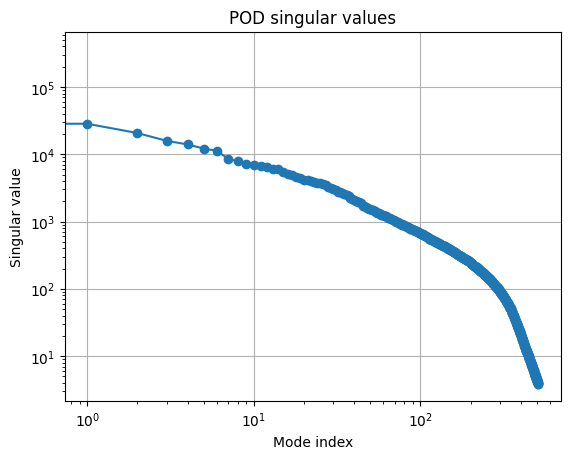

Requested modes=1000, obtained modes r=509


In [105]:
# ==========================================================
# 3) POD basis construction
# ==========================================================

max_modes = 1000

space = NumpyVectorSpace(ndofs)
snapshots_va = space.from_numpy(X.T)     # shape (nsnap, ndofs)

req_modes = min(max_modes, len(snapshots_va))
RB_va, svals= pod(snapshots_va, modes=req_modes,rtol=1e-5)

plt.loglog(svals, 'o-')
plt.title('POD singular values')
plt.xlabel('Mode index')
plt.ylabel('Singular value')
plt.grid()
plt.show()

Vrb = RB_va.to_numpy().T                # columns: POD basis vecs
r = Vrb.shape[1]
print(f"Requested modes={req_modes}, obtained modes r={r}")

if r == 0:
    raise RuntimeError("POD returned zero modes (rank-deficient snapshots).")
if r == 1:
    print("Warning: only 1 POD mode found — parameter variation may be too simple.")

# ==========================================================
# 4) Reduced operators (offline)
# ==========================================================
# Precompute reduced matrices for each κ entry
A11r = Vrb.T @ np.column_stack([apply_Acomp(Vrb[:, j], a11) for j in range(r)])
A12r = Vrb.T @ np.column_stack([apply_Acomp(Vrb[:, j], a12) for j in range(r)])
A21r = Vrb.T @ np.column_stack([apply_Acomp(Vrb[:, j], a21) for j in range(r)])
A22r = Vrb.T @ np.column_stack([apply_Acomp(Vrb[:, j], a22) for j in range(r)])

# Reduced RHS
fr = Vrb.T @ f_vec


In [111]:
# ==========================================================
# 5) Online reduced solve
# ==========================================================
def solve_reduced(kappa: np.ndarray) -> np.ndarray:
    """Solve ROM for 2x2 constant κ tensor."""
    Ar = (
        kappa[0, 0] * A11r
        + kappa[0, 1] * A12r
        + kappa[1, 0] * A21r
        + kappa[1, 1] * A22r
    )
    y = np.linalg.solve(Ar, fr)
    return Vrb @ y

# ==========================================================
# 6) Test on unseen κ
# ==========================================================
kappa_test = np.array([[4., 1.0],
                       [1.0, 4.0]])
u_rom = solve_reduced(kappa_test)
u_fom = solve_full(kappa_test)
rel_err = np.linalg.norm(u_fom - u_rom) / np.linalg.norm(u_fom)
print(f"Relative error for kappa={kappa_test.tolist()}: {rel_err:.3e}")

# ==========================================================
# 7) Optional visualization
# ==========================================================
try:
    from ngsolve.webgui import Draw
    gfu_fom = GridFunction(V); gfu_fom.vec[:] = u_fom
    gfu_rom = GridFunction(V); gfu_rom.vec[:] = u_rom
    Draw(gfu_rom, mesh, "ROM")
    Draw(gfu_fom, mesh, "FOM")
except Exception as ex:
    print("Visualization skipped:", ex)


Relative error for kappa=[[4.0, 1.0], [1.0, 4.0]]: 6.235e-02


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…